# 02.10.20 - SVM MFCC20 (4-Fold, unbalanced, standard SVC)


## Prerequisites

- The dataset exists (if not, execute 02.00.01)
- The dataset features have been populated (if not, execute 02.00.02)


## Goals

In this experiment, we intend to assess the generalization capability of a SVM using MFCC coefficients as features, through a 4-folds cross validation over the hive axis.

In reality, due to the fact that some hives in the reference dataset only present one label value (either queen of noqueen) some folds are an agregate of 2 distincts hives, but in any case, for each fold, the classifier is tested over samples belonging to hive(s) it was never trained on. 

Distribution details are provided below:

<table border="1" class="dataframe" align="left">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fold</th>
      <th>hive</th>
      <th>queen</th>
      <th>count(*)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>CF001</td>
      <td>0.0</td>
      <td>14</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>CF003</td>
      <td>1.0</td>
      <td>3649</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>CJ001</td>
      <td>0.0</td>
      <td>790</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>GH001</td>
      <td>1.0</td>
      <td>1396</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>Hive1</td>
      <td>0.0</td>
      <td>1473</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3</td>
      <td>Hive1</td>
      <td>1.0</td>
      <td>2684</td>
    </tr>
    <tr>
      <th>6</th>
      <td>4</td>
      <td>Hive3</td>
      <td>0.0</td>
      <td>6545</td>
    </tr>
    <tr>
      <th>7</th>
      <td>4</td>
      <td>Hive3</td>
      <td>1.0</td>
      <td>654</td>
    </tr>
  </tbody>
</table>
<br><br><br><br><br><br><br><br><br><br><br><br><br>


For some folds (see table below), queen/noqueen representation is heavily unbalanced, but in this experiment, no measure is taken to mitigate this fact.

<table border="1" class="dataframe" align="left">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fold</th>
      <th>Q</th>
      <th>NQ</th>
      <th>Q_ratio</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>3649</td>
      <td>14</td>
      <td>99.62%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>1396</td>
      <td>790</td>
      <td>63.86%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>3</td>
      <td>2684</td>
      <td>1473</td>
      <td>64.57%</td>
    </tr>
    <tr>
      <th>3</th>
      <td>4</td>
      <td>654</td>
      <td>6545</td>
      <td>9.08%</td>
    </tr>
  </tbody>
</table>
<br><br><br><br><br><br><br><br>

## Conclusion

**The SVM classifier demonstrates extremely poor generalization, regardless of the parameters we have tested so far.**


<hr style="border:1px solid gray"></hr>

### Step 1: Get previously created dataset

In [6]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information  
    predestination,                  # Seeds various PRNGs for reproducibility
    say_my_name                      # gets notebook name
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling

from IPython.display import display

#########################
# Experiment parameters #
#########################

EXP_NAME = say_my_name()  # Experiment name will be used to create outputs directory

DATASET_NAME = 'MAIN1000' # Dataset name is the master key for dataset addressing
                          # Change it according to the dataset you want to process


FEATURE_NAME = 'mfcc20'   # Name of the feature used for classification
LABEL_NAME = 'queen'      # Name of the label used for classification
FOLD_NAME = 'fold'        # Column name of the fold axis

KERNEL = 'rbf'            # svm kernel
C = 1                     # svm penalty factor
GAMMA = 'scale'           # rbf kernel gamma factor

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Build dataframe containing all the information needed to conduct the experiment
sql = F"SELECT {FEATURE_NAME}, {LABEL_NAME}, {FOLD_NAME} FROM samples WHERE nobee = 0"
df = ds.queryDataFrame(sql)

# Display cardinalities by hive attribute and queen label for samples with no external perturbation
sql = """
    select distinct fold, queen, count(*)
    from samples
    where nobee = 0
    group by fold, queen
    order by fold, queen
    """
display(ds.queryDataFrame(sql))

# display distribution per fold
print("\n======  PER FOLD QUEEN/NOQUEEN DISTRIBUTION ======")
sql = """
    select distinct fold,
    count(case queen when 1.0 then 1 else null end) as Q,
    count(case queen when 0.0 then 1 else null end) as NQ,
    round(100.0*count(case queen when 1.0 then 1 else null end)/count(*), 2)||'%'  as Q_ratio
    from samples
    where nobee = 0
    group by fold
    order by fold
    """
display(ds.queryDataFrame(sql))


# display global distribution
print("\n======  GLOBAL QUEEN/NOQUEEN DISTRIBUTION ======")
sql = """
    select
    count(case queen when 1.0 then 1 else null end) as Q,
    count(case queen when 0.0 then 1 else null end) as NQ,
    round(100.0*count(case queen when 1.0 then 1 else null end)/count(*), 2)||'%'  as Q_ratio
    from samples
    where nobee = 0
    """
display(ds.queryDataFrame(sql))

[2020-09-07/12:07:55.654|08.0%|83.3%|0.58GB] ------------------------------------------------------
[2020-09-07/12:07:55.654|00.0%|83.3%|0.58GB] DATASET NAME          : CMAIN1000
[2020-09-07/12:07:55.654|00.0%|83.3%|0.58GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\CMAIN1000
[2020-09-07/12:07:55.654|00.0%|83.3%|0.58GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\CMAIN1000\CMAIN1000.db
[2020-09-07/12:07:55.655|00.0%|83.3%|0.58GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\CMAIN1000\samples
[2020-09-07/12:07:55.655|00.0%|83.3%|0.58GB] NB SOURCE AUDIO FILES : 48
[2020-09-07/12:07:55.655|00.0%|83.3%|0.58GB] SAMPLE RATE           : 22050
[2020-09-07/12:07:55.655|00.0%|83.3%|0.58GB] DURATION              : 1.0
[2020-09-07/12:07:55.655|00.0%|83.3%|0.58GB] OVERLAP               : 0.0
[2020-09-07/12:07:55.656|00.0%|83.3%|0.58GB] NB AUDIO CHUNKS       : 24788
[2020-09-07/12:07:55.656|00.0%|83.3%|0.58GB] ------------------------------------------------------


,fold,queen,count(*)
0,1,0.0,14
1,1,1.0,3649
2,2,0.0,790
3,2,1.0,1396
4,3,0.0,1473
5,3,1.0,2684
6,4,0.0,6545
7,4,1.0,654



======  PER FOLD QUEEN/NOQUEEN DISTRIBUTION ======


,fold,Q,NQ,Q_ratio
0,1,3649,14,99.62%
1,2,1396,790,63.86%
2,3,2684,1473,64.57%
3,4,654,6545,9.08%



======  GLOBAL QUEEN/NOQUEEN DISTRIBUTION ======


,Q,NQ,Q_ratio
0,8383,8822,48.72%


<hr style="border:1px solid gray"></hr>

### Step 2: Process SVM learning and display performance indicators

In [2]:
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
from audace.splitters import splitTrainTestFold

#########################
# Experiment parameters #
#########################


# Seed the various PRNGs
predestination()


X_tests = []
y_tests = []
clfs = []

# Iterate over folds
for fold in ds.listAttributeValues(FOLD_NAME):
    print(F"############### FOLD {fold} ###############")
    # Build training and test datasets
    iprint(">>>>> Building partitions training/test")
    X_train, X_test, y_train, y_test = splitTrainTestFold(
        df,
        FEATURE_NAME,
        LABEL_NAME,
        FOLD_NAME,
        fold
    )

    # Standardize data 
    iprint(">>>>> Standardize")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #Create a SVM Classifier, using the experiment parameters
    clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

    #Train the model using the training sets
    iprint('>>>>> Train')
    clf.fit(X_train, y_train)
    
    #Store data (will be used later for reporting)
    X_tests.append(X_test)
    y_tests.append(y_test)
    clfs.append(clf)    
    

    #Predict the response for test dataset
    iprint('>>>>> Predict')
    y_pred = clf.predict(X_test)

    # Display information about the classifier performance
    iprint(F"Trained over {len(y_train)} / Tested over {len(y_test)}")
    iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
    iprint("Precision :",metrics.precision_score(y_test, y_pred))
    iprint("Recall    :",metrics.recall_score(y_test, y_pred))
    iprint("F-Measure :",metrics.f1_score(y_test, y_pred))


############### FOLD 1 ###############
[2020-09-07/11:36:49.794|09.0%|79.2%|0.35GB] >>>>> Building partitions training/test
[2020-09-07/11:36:49.884|15.9%|80.0%|0.41GB] >>>>> Standardize
[2020-09-07/11:36:50.176|15.8%|80.1%|0.41GB] >>>>> Train
[2020-09-07/11:38:41.219|15.9%|81.2%|0.46GB] >>>>> Predict
[2020-09-07/11:39:07.233|14.1%|81.0%|0.46GB] Trained over 13542 / Tested over 3663
[2020-09-07/11:39:07.244|00.0%|81.0%|0.46GB] Accuracy  : 0.082992082992083
[2020-09-07/11:39:07.247|16.7%|81.0%|0.46GB] Precision : 0.9865771812080537
[2020-09-07/11:39:07.250|00.0%|81.0%|0.46GB] Recall    : 0.08057001918333791
[2020-09-07/11:39:07.252|00.0%|81.0%|0.46GB] F-Measure : 0.14897390423106158
############### FOLD 2 ###############
[2020-09-07/11:39:07.252|00.0%|81.0%|0.46GB] >>>>> Building partitions training/test
[2020-09-07/11:39:07.337|12.8%|81.2%|0.47GB] >>>>> Standardize
[2020-09-07/11:39:07.663|18.9%|81.3%|0.47GB] >>>>> Train
[2020-09-07/11:41:11.255|15.4%|81.4%|0.51GB] >>>>> Predict
[2020-

<hr style="border:1px solid gray"></hr>

### Step 3: Display performance report


[2020-09-07/11:45:07.280|06.4%|81.9%|0.59GB] ========== FOLD 1 ==========


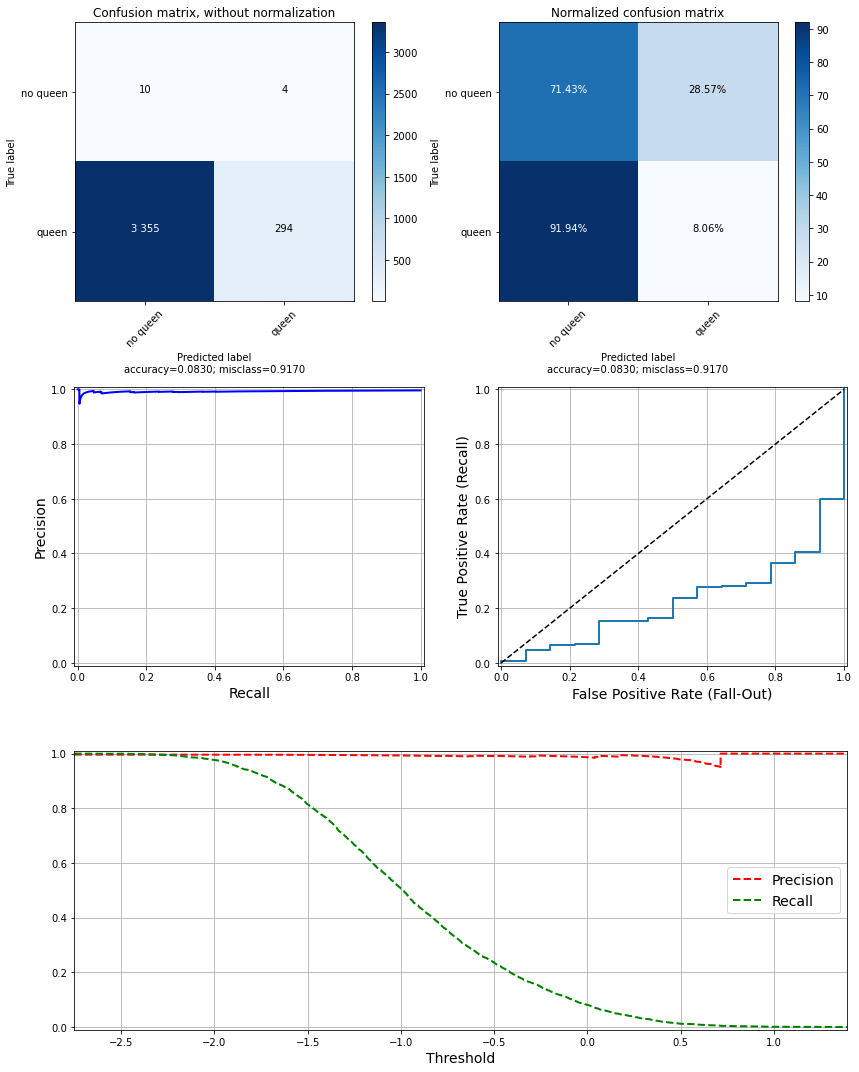

[2020-09-07/11:46:52.548|14.4%|81.8%|0.60GB] >>>>> Predict
[2020-09-07/11:47:19.700|15.8%|82.1%|0.60GB] Accuracy  : 0.082992082992083
[2020-09-07/11:47:19.703|00.0%|82.1%|0.60GB] Precision : 0.9865771812080537
[2020-09-07/11:47:19.705|00.0%|82.1%|0.60GB] Recall    : 0.08057001918333791
[2020-09-07/11:47:19.707|00.0%|82.1%|0.60GB] F-Measure : 0.14897390423106158
[2020-09-07/11:47:19.707|00.0%|82.1%|0.60GB] ========== FOLD 2 ==========


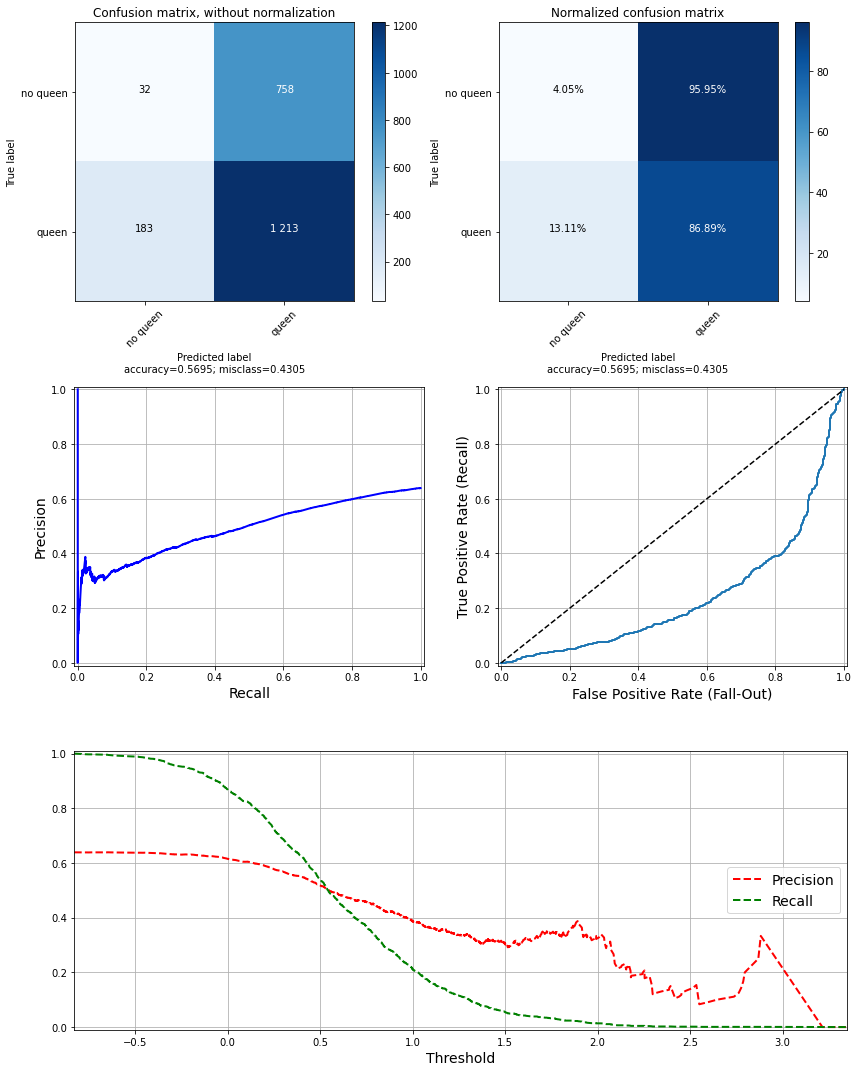

[2020-09-07/11:48:22.197|15.5%|82.6%|0.61GB] >>>>> Predict
[2020-09-07/11:48:38.440|17.1%|82.9%|0.61GB] Accuracy  : 0.5695333943275389
[2020-09-07/11:48:38.442|00.0%|82.9%|0.61GB] Precision : 0.6154236428209031
[2020-09-07/11:48:38.444|00.0%|82.9%|0.61GB] Recall    : 0.8689111747851003
[2020-09-07/11:48:38.446|00.0%|82.9%|0.61GB] F-Measure : 0.7205227205227206
[2020-09-07/11:48:38.446|00.0%|82.9%|0.61GB] ========== FOLD 3 ==========


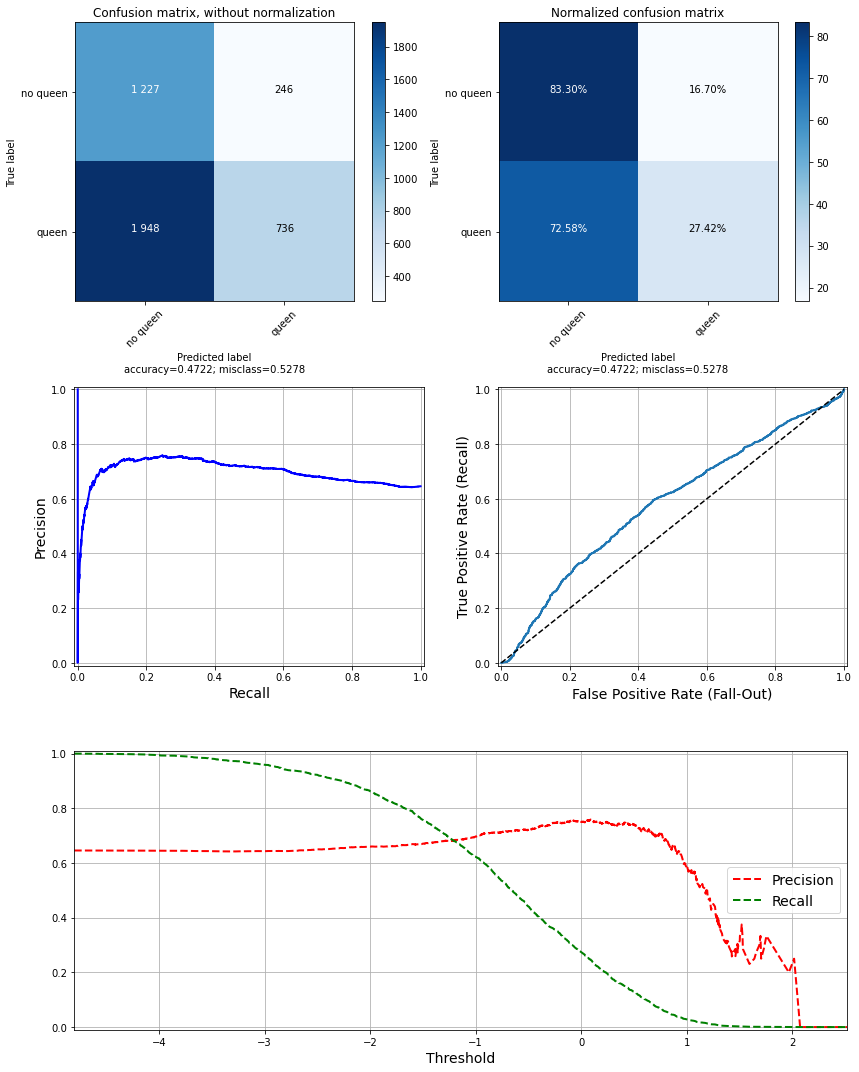

[2020-09-07/11:49:37.663|13.9%|82.2%|0.62GB] >>>>> Predict
[2020-09-07/11:49:52.448|14.0%|82.2%|0.62GB] Accuracy  : 0.47221554005292277
[2020-09-07/11:49:52.451|25.0%|82.2%|0.62GB] Precision : 0.7494908350305499
[2020-09-07/11:49:52.454|00.0%|82.2%|0.62GB] Recall    : 0.27421758569299554
[2020-09-07/11:49:52.456|00.0%|82.2%|0.62GB] F-Measure : 0.4015275504637207
[2020-09-07/11:49:52.456|00.0%|82.2%|0.62GB] ========== FOLD 4 ==========


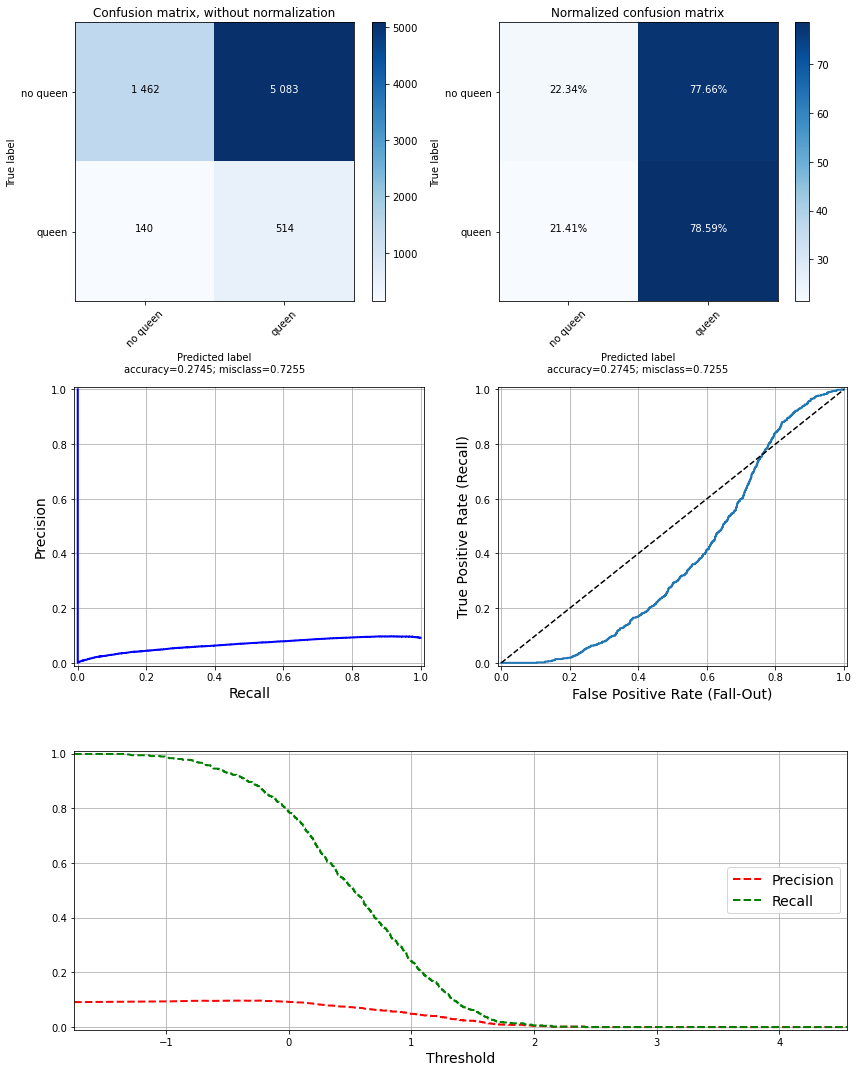

[2020-09-07/11:51:36.190|16.1%|81.9%|0.61GB] >>>>> Predict
[2020-09-07/11:52:03.014|17.0%|81.8%|0.61GB] Accuracy  : 0.2744825670231977
[2020-09-07/11:52:03.018|00.0%|81.8%|0.61GB] Precision : 0.09183491155976416
[2020-09-07/11:52:03.022|00.0%|81.8%|0.61GB] Recall    : 0.7859327217125383
[2020-09-07/11:52:03.025|00.0%|81.8%|0.61GB] F-Measure : 0.16445368741001437


In [3]:
from audace.plotters import clf_full_report
from audace.metrics import i_may_be_wrong

for i, fold in enumerate(ds.listAttributeValues(FOLD_NAME)):
    iprint(F"========== FOLD {fold} ==========")
    clf_full_report(clfs[i], X_tests[i], y_tests[i], target_names = ['no queen', 'queen'])
    
    # Predict the response for test dataset
    y_pred = clfs[i].predict(X_tests[i])

    # Display information about the classifier performance
    iprint("Accuracy  :",metrics.accuracy_score(y_tests[i], y_pred))
    iprint("Precision :",metrics.precision_score(y_tests[i], y_pred))
    iprint("Recall    :",metrics.recall_score(y_tests[i], y_pred))
    iprint("F-Measure :",metrics.f1_score(y_tests[i], y_pred))
